In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold

# F1

In [ ]:
def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/파이널 프로젝트/train_images_processed_512"
TEST_PATH = "/content/drive/MyDrive/파이널 프로젝트/data1/test_images"

# 데이터셋

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/파이널 프로젝트/data1/train.csv")
# 'img_name'컬럼 추가 = (patient_id)/(image_id).png
df["img_name"] = df["patient_id"].astype(str) + "/" + df["image_id"].astype(str) + ".png"
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,10011/220375232.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,9973/1729524723.png
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,9989/63473691.png
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,9989/1078943060.png
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,9989/398038886.png


In [ ]:
# 데이터 섞기
df = df.sample(frac=1).reset_index(drop=True)
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,1,57415,1128967170,L,MLO,56.0,0,0,0,1.0,0,A,49,False,57415/1128967170.png
1,1,24490,2011349525,L,CC,58.0,0,0,0,1.0,0,C,49,False,24490/2011349525.png
2,2,53295,246023985,R,CC,56.0,0,0,0,NaN,0,NaN,29,False,53295/246023985.png
3,2,4017,1610583007,R,CC,69.0,0,0,0,NaN,0,NaN,29,False,4017/1610583007.png
4,1,21640,867600582,L,MLO,46.0,0,0,0,0.0,0,B,170,True,21640/867600582.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,2,41183,757466450,R,MLO,50.0,0,0,0,0.0,0,NaN,21,True,41183/757466450.png
54702,2,43843,623907172,R,MLO,52.0,0,0,0,NaN,0,NaN,21,False,43843/623907172.png
54703,2,1791,631067871,R,CC,62.0,0,0,0,NaN,0,NaN,29,False,1791/631067871.png
54704,2,15464,2075992898,R,MLO,53.0,0,0,0,NaN,0,NaN,48,False,15464/2075992898.png


In [ ]:
undersample_amount = len(df[df["cancer"]==1])
dfnotcancer = df[df["cancer"]==0].sample(undersample_amount).reset_index(drop=True)
dfcancer = df[df["cancer"]==1].reset_index(drop=True)

In [ ]:
dfnotcancer

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,2,62679,150124108,R,MLO,70.0,0,0,0,NaN,0,NaN,29,False,62679/150124108.png
1,2,56161,260545784,R,CC,61.0,0,0,0,NaN,0,NaN,48,False,56161/260545784.png
2,1,51717,1330244770,R,MLO,67.0,0,1,0,0.0,0,C,49,True,51717/1330244770.png
3,1,25705,995948966,R,MLO,67.0,0,0,0,1.0,0,C,216,False,25705/995948966.png
4,1,38531,486757630,R,CC,58.0,0,0,0,1.0,0,C,49,False,38531/486757630.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,1,27212,900539670,R,MLO,NaN,0,0,0,0.0,0,D,49,True,27212/900539670.png
1154,2,21649,1155521173,L,MLO,56.0,0,0,0,NaN,0,NaN,29,False,21649/1155521173.png
1155,2,7279,1543060877,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False,7279/1543060877.png
1156,2,53262,833751551,R,MLO,75.0,0,0,0,NaN,0,NaN,48,False,53262/833751551.png


In [ ]:
dfcancer

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,1,13101,739781139,R,MLO,58.0,1,1,1,0.0,0,B,49,False,13101/739781139.png
1,1,26700,476723525,R,CC,54.0,1,1,1,0.0,0,D,49,False,26700/476723525.png
2,1,29986,535786162,R,CC,66.0,1,1,1,0.0,0,B,49,False,29986/535786162.png
3,1,28989,506550282,R,MLO,52.0,1,1,1,0.0,0,C,49,False,28989/506550282.png
4,2,17562,104106029,L,CC,66.0,1,1,1,NaN,0,NaN,29,False,17562/104106029.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,2,9201,18384498,L,CC,58.0,1,1,1,NaN,0,NaN,29,False,9201/18384498.png
1154,1,59865,835658415,R,MLO,56.0,1,1,1,0.0,0,D,49,False,59865/835658415.png
1155,2,65492,1186509485,L,MLO,59.0,1,1,1,NaN,0,NaN,48,False,65492/1186509485.png
1156,1,13267,1789731455,R,CC,43.0,1,1,0,0.0,0,C,49,False,13267/1789731455.png


In [ ]:
# 위의 두 개의 테이블을 합치기 
dff = pd.concat([dfcancer, dfnotcancer]).sample(frac=1).reset_index(drop=True)

print(f"처음 테이블의 형태: {df.shape}\n 합친 테이블의 형태: {dff.shape}")

dff.head()

처음 테이블의 형태: (54706, 15)
 합친 테이블의 형태: (2316, 15)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,1,47542,1488476294,R,CC,62.0,0,0,0,1.0,1,B,49,False,47542/1488476294.png
1,1,10523,1235422671,R,CC,45.0,0,0,0,1.0,0,B,49,False,10523/1235422671.png
2,1,24490,1306355749,R,MLO,58.0,0,0,0,1.0,0,C,49,False,24490/1306355749.png
3,2,55095,462557364,R,MLO,75.0,1,1,1,NaN,0,NaN,21,False,55095/462557364.png
4,2,40576,2146445857,R,CC,50.0,1,1,0,NaN,0,NaN,21,False,40576/2146445857.png


In [ ]:
def img2roi(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img * 255, dtype = np.uint8)
    # 이미지 이진화
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # 영상 주위에 윤곽선을 만들고 가장 큰 윤곽선만 유지 
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # 가장 큰 윤곽선에서 ROI 찾기
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi =  img[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
    return roi

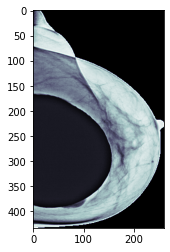

In [ ]:
plt.imshow(img2roi(cv2.imread(TRAIN_PATH+"/"+dff.img_name[0])), cmap="bone")

# Augmentation

In [ ]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.RandomVerticalFlip(),
            transforms.RandomEqualize(),
            transforms.ToTensor()
        ])

# 데이터셋 생성

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, img_folder, transform=transform, is_test=False):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test
        self.test_folder = "/content/drive/MyDrive/파이널 프로젝트/"
    
    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.test_folder, self.df["img_name"][idx])
        else:
            img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
        img = cv2.imread(img_path)
        img = img2roi(img)
            
        #print(img.shape)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)    
        img = torch.tensor(img, dtype=torch.float)
        #img = img.permute(2, 1, 0)
        if not self.is_test:
            target = self.df["cancer"][idx]
            target = torch.tensor(target, dtype=torch.float)
            return img, target
        img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

In [ ]:
split = .95
df = dff.sample(frac=1).reset_index(drop=True)
train_samples = int(len(df) * split)
train_df = df[:train_samples+1].reset_index(drop=True)
val_df = df[train_samples:].reset_index(drop=True)


In [ ]:
train_dataset = RSNADataset(df=train_df, img_folder=TRAIN_PATH, transform=transform)
valid_dataset = RSNADataset(df=val_df, img_folder=TRAIN_PATH, transform=transform)
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# 이미지 확인

In [ ]:
def show_aug(inputs, targets, nrows=4, ncols=4, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

<ipython-input-14-d60bcb19dc64>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


torch.Size([16, 1, 224, 224]) torch.Size([16])


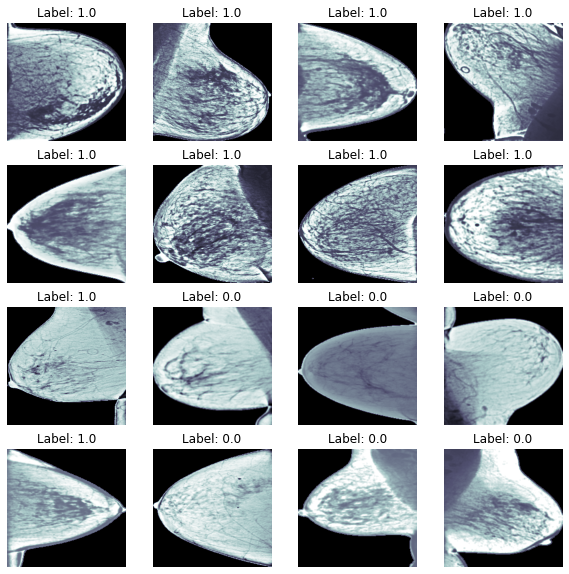

In [ ]:
images, targets = next(iter(train_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

<ipython-input-14-d60bcb19dc64>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


torch.Size([16, 1, 224, 224]) torch.Size([16])


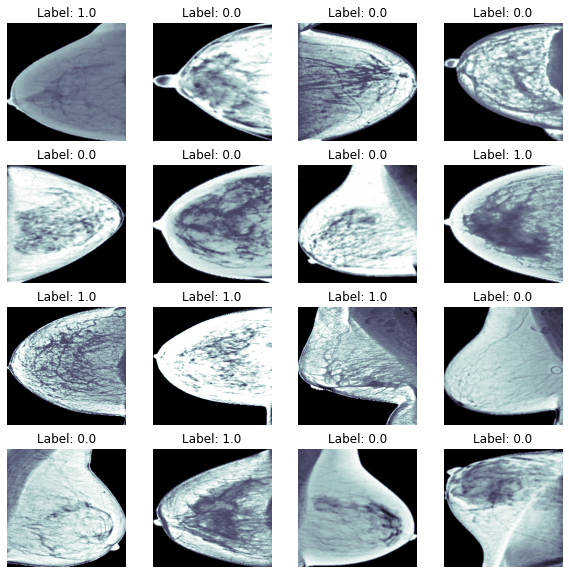

In [ ]:
images, targets = next(iter(val_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

# 모델 불러오기

In [ ]:
class EfficientNetV2_xl(torch.nn.Module):
    def __init__(self, model_name="efficientnet_b0",pretrained=False, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [ ]:
EfficientNetV2_xl()

EfficientNetV2_xl(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
n_epochs = 10

In [ ]:
len(train_loader)

138

In [ ]:
def fit(model, epochs, train_loader, valid_loader, optimizer, loss_fn):
    
    train_loss, val_loss = [], []
    f1_score_hist = []
    
    for ep in tqdm(range(epochs+1)):
        print(f"{35*'='} Epoch:{ep+1} {35*'='}")
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        # training
        for idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images).view(-1)
            loss = loss_fn(outputs, targets.float())
            
                        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            
            if idx % 100 == 0:
                print(f"Batch: {idx} | Train Batch Loss: {loss.item():.4f}")
        
        train_loss.append(running_loss / len(train_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Training Loss: {np.mean(train_loss):.4f}\n")
        
        
        # validation        
        all_outputs, all_targets = [], []
        correct_t = 0
        batch_loss = 0
        total_t = 0
        with torch.no_grad():
            #model.eval()
            for idx, (images_t, targets_t) in enumerate(valid_loader):
                images_t = images_t.to(device)
                targets_t = targets_t.to(device)
                
                outputs_t = model(images_t).view(-1)
             
                loss_t = loss_fn(outputs_t, targets_t.float())
                
                batch_loss += loss_t.item()
                
                if idx % 10 == 0:
                    print(f"\nBatch: {idx} | Valid Batch Loss: {loss_t.item():.4f}")
                
                all_outputs.extend(torch.sigmoid(outputs_t).cpu().detach().tolist())
                all_targets.extend(targets_t.cpu().detach().tolist())
        prob_f1_score = probabilistic_f1(all_targets, all_outputs)
        
        f1_score_hist.append(prob_f1_score)
        val_loss.append(batch_loss/len(val_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Validation Loss: {np.mean(val_loss):.4f}\n")
        print(f"\nF1 Score for Epoch {ep+1}: {prob_f1_score:.4f}\n")
                
        
    torch.save(model.state_dict(), "/content/drive/MyDrive/파이널 프로젝트/second.pth")
    
    return train_loss, val_loss, f1_score_hist

In [ ]:
def run(train_loader, val_loader, epochs=n_epochs):
    model = EfficientNetV2_xl().to(device)
    
    optimizer = torch.optim.Adamax(params=model.parameters(), weight_decay=1e-2)
    loss_fn = nn.BCEWithLogitsLoss()
    
    train_loss, val_loss, f1_score_hist = fit(model=model, epochs=epochs, train_loader=train_loader,
        valid_loader=val_loader, optimizer=optimizer,
       loss_fn=loss_fn)
    return train_loss, val_loss, f1_score_hist

In [ ]:
train_loss, val_loss, f1_score_hist = run(train_loader, val_loader, n_epochs)

  0%|          | 0/11 [00:00<?, ?it/s]

=================================== Epoch:1 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

<ipython-input-14-d60bcb19dc64>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


Batch: 0 | Train Batch Loss: 0.6814
Batch: 100 | Train Batch Loss: 0.7085

Epoch: 1 / 10 | Training Loss: 0.7195


Batch: 0 | Valid Batch Loss: 0.7191

Epoch: 1 / 10 | Validation Loss: 0.6954


F1 Score for Epoch 1: 0.3518

=================================== Epoch:2 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.7376
Batch: 100 | Train Batch Loss: 0.7057

Epoch: 2 / 10 | Training Loss: 0.7083


Batch: 0 | Valid Batch Loss: 0.7201

Epoch: 2 / 10 | Validation Loss: 0.6971


F1 Score for Epoch 2: 0.3603

=================================== Epoch:3 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6997
Batch: 100 | Train Batch Loss: 0.8153

Epoch: 3 / 10 | Training Loss: 0.7044


Batch: 0 | Valid Batch Loss: 0.6968

Epoch: 3 / 10 | Validation Loss: 0.6958


F1 Score for Epoch 3: 0.3609

=================================== Epoch:4 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6841
Batch: 100 | Train Batch Loss: 0.6801

Epoch: 4 / 10 | Training Loss: 0.7017


Batch: 0 | Valid Batch Loss: 0.7036

Epoch: 4 / 10 | Validation Loss: 0.6926


F1 Score for Epoch 4: 0.3656

=================================== Epoch:5 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6792
Batch: 100 | Train Batch Loss: 0.7055

Epoch: 5 / 10 | Training Loss: 0.7001


Batch: 0 | Valid Batch Loss: 0.6894

Epoch: 5 / 10 | Validation Loss: 0.6925


F1 Score for Epoch 5: 0.3589

=================================== Epoch:6 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6961
Batch: 100 | Train Batch Loss: 0.7139

Epoch: 6 / 10 | Training Loss: 0.6990


Batch: 0 | Valid Batch Loss: 0.6902

Epoch: 6 / 10 | Validation Loss: 0.6931


F1 Score for Epoch 6: 0.3573

=================================== Epoch:7 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6877
Batch: 100 | Train Batch Loss: 0.6930

Epoch: 7 / 10 | Training Loss: 0.6980


Batch: 0 | Valid Batch Loss: 0.6858

Epoch: 7 / 10 | Validation Loss: 0.6933


F1 Score for Epoch 7: 0.3576

=================================== Epoch:8 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6726
Batch: 100 | Train Batch Loss: 0.6906

Epoch: 8 / 10 | Training Loss: 0.6971


Batch: 0 | Valid Batch Loss: 0.6982

Epoch: 8 / 10 | Validation Loss: 0.6933


F1 Score for Epoch 8: 0.3577

=================================== Epoch:9 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6904
Batch: 100 | Train Batch Loss: 0.6974

Epoch: 9 / 10 | Training Loss: 0.6965


Batch: 0 | Valid Batch Loss: 0.6938

Epoch: 9 / 10 | Validation Loss: 0.6934


F1 Score for Epoch 9: 0.3573

=================================== Epoch:10 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6900
Batch: 100 | Train Batch Loss: 0.6898

Epoch: 10 / 10 | Training Loss: 0.6961


Batch: 0 | Valid Batch Loss: 0.6941

Epoch: 10 / 10 | Validation Loss: 0.6932


F1 Score for Epoch 10: 0.3571

=================================== Epoch:11 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6963
Batch: 100 | Train Batch Loss: 0.6935

Epoch: 11 / 10 | Training Loss: 0.6958


Batch: 0 | Valid Batch Loss: 0.6939

Epoch: 11 / 10 | Validation Loss: 0.6932


F1 Score for Epoch 11: 0.3578



In [ ]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train loss', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation loss', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

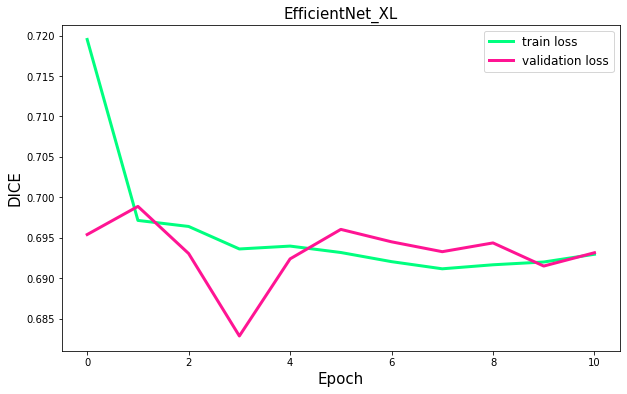

In [ ]:
plot_model_history("EfficientNet_XL", train_loss, val_loss, num_epochs=n_epochs+1)

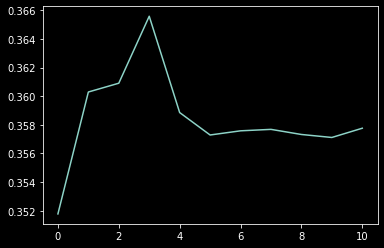

In [ ]:
plt.style.use("dark_background")

plt.plot(range(n_epochs+1), f1_score_hist)

In [ ]:
!pip install dicomsdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.9 MB/s eta 0:00:00


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.2 MB/s eta 0:00:00


In [ ]:
import dicomsdl
import cv2
import pydicom
from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt

In [ ]:
test_images = glob.glob("/content/drive/MyDrive/파이널 프로젝트/data1/test_images/*/*.dcm")
len(test_images)

4

In [ ]:
def process(f, size = 512, save_folder=None, dicom_process = False, extension="png"):

  patient = f.split('/')[-2]
  image_name = f.split('/')[-1][:-4]
  if dicom_process: 
    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == "MONOCHROME1": 
      img = 1- img

    image = (img*255).astype(np.unit8)

  else:
    dicom = dicomsdl.open(f)
    img = dicom.pixelData()

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == "MONOCHROME1":
      img = 1 - img

    image = (img*255).astype(np.uint8)

  img = cv2.resize(image, (size, size))

  file_name = f'{save_folder}' + f"{patient}_{image_name}.{extension}"

  cv2.imwrite(file_name,img)


In [ ]:
image_dir_dicomsdl = '/content/drive/MyDrive/파이널 프로젝트/'

os.makedirs(image_dir_dicomsdl, exist_ok = True)

In [ ]:
Parallel(n_jobs=4)(
    delayed(process)(f, size = 512, save_folder = image_dir_dicomsdl, dicom_process = False)
    for f in tqdm(test_images)
)

  0%|          | 0/4 [00:00<?, ?it/s]

[None, None, None, None]

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/파이널 프로젝트/data1/test.csv")
df_test["img_name"] = df_test["patient_id"].astype(str) + "_" + df_test["image_id"].astype(str) + ".png"
df_test['dcm_path'] = df_test["patient_id"].astype(str) + "_" + df_test["image_id"].astype(str) + ".dcm"

df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008_736471439.png,10008_736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008_1591370361.png,10008_1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008_68070693.png,10008_68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008_361203119.png,10008_361203119.dcm


In [ ]:
test_dataset=RSNADataset(df=df_test, img_folder=TEST_PATH, transform=None, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

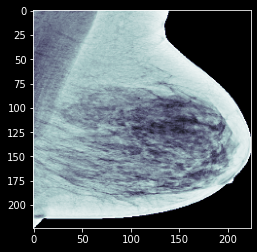

In [ ]:
plt.imshow(next(iter(test_loader))[0][0], cmap="bone")

In [ ]:
def prediction_model(model, test_loader):
  model.eval()

  with torch.no_grad():
    preds = []
    if len(test_loader) != 1:
      for images, targets in tqdm(test_loader, total = len(test_loader)):
        for im in tqdm(images):
          pred = model(im.unsqueeze(0).float())
          preds.append(pred)
    else:
      for batch in tqdm(test_loader, total=len(test_loader)):
        for im in tqdm(batch):
          pred = model(im.unsqueeze(0).float())
          preds.append(pred)
    return torch.concat(preds).numpy()

In [ ]:
preds = prediction_model(EfficientNetV2_xl(), test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
preds

array([[-10.022948 ],
       [ -4.4052324],
       [-11.67197  ],
       [-10.055772 ]], dtype=float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()  
scaled_preds = ss.fit_transform(preds)

In [ ]:
sub_df = pd.read_csv("/content/drive/MyDrive/파이널 프로젝트/data1/sample_submission.csv")
sub_df

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [ ]:
df_test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008_736471439.png,10008_736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008_1591370361.png,10008_1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008_68070693.png,10008_68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008_361203119.png,10008_361203119.dcm


In [ ]:
prediction_id = df_test['patient_id'].astype(str) + "_" + df_test['laterality'] 

In [ ]:
prediction_id

0    10008_L
1    10008_L
2    10008_R
3    10008_R
dtype: object

In [ ]:
threshold = .50

In [ ]:
sub_preds = scaled_preds.copy()

sub_preds[sub_preds > threshold] = 1
sub_preds[sub_preds <= threshold] = 0

In [ ]:
data = {
    "prediction_id" : np.array((prediction_id)),
    "cancer" : sub_preds.T[0]
}

sub_df = pd.DataFrame(data = data)

In [ ]:
subb = sub_df.drop_duplicates("prediction_id")
subb

,prediction_id,cancer
0,10008_L,0.0
2,10008_R,0.0


In [ ]:
subb.to_csv("first_submission", index = False)